In [116]:
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
df = pd.read_csv("data/merged_data.csv" )

**80-20 Train-Test Split**

In [119]:
df.shape[0]

59

In [120]:
train = df.iloc[:round(df.shape[0] * 0.8), :].copy()
test = df.iloc[round(df.shape[0] * 0.8):, ].copy()

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              47 non-null     int64  
 1   population        47 non-null     float64
 2   gdp               47 non-null     float64
 3   co2               47 non-null     float64
 4   solar_generation  29 non-null     float64
 5   wind_generation   29 non-null     float64
 6   hydro_generation  47 non-null     float64
 7   other_generation  47 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 3.1 KB


**Imputing Missing Values**

There are missing values in solar_generation and wind_generation that we need to account for.
We will impute them by assuming the missing values are placeholders for 0. This makes sense because in 1983 when the data becomes not missing, the values are very small. Moreover, we will combine all four clean energy generation sources into a "total_generation" feature, because we do not care about the source of the clean energy generation.

In [122]:
train["solar_generation"] = train["solar_generation"].fillna(0)
train["wind_generation"] = train["wind_generation"].fillna(0)
train["total_generation"] = train["solar_generation"] + train["wind_generation"] + train["hydro_generation"] + train["other_generation"]

In [123]:
train.head()

,year,population,gdp,co2,solar_generation,wind_generation,hydro_generation,other_generation,total_generation
0,1965,195653775.0,4.156140e+12,3399.547,0.0,0.0,198.97409,13.332232,212.306322
1,1966,198265397.0,4.428300e+12,3571.421,0.0,0.0,199.93690,14.062007,213.998907
2,1967,200699913.0,4.538980e+12,3705.461,0.0,0.0,227.22081,14.073571,241.294381
3,1968,203011021.0,4.754930e+12,3840.919,0.0,0.0,228.15471,15.546045,243.700755
4,1969,205300032.0,4.903770e+12,4035.145,0.0,0.0,256.02853,16.227060,272.255590


Since the latest value for gdp is missing only, we can assume it is missing because the dataset did not collect the data yet. We will impute it by linear extrapolation, since the increase in gdp between 2021 and 2022 should be pretty similar to the increase in gdp between 2022 and 2023.

**Checking For Outliers**

Text(0.5, 1.0, 'co2')

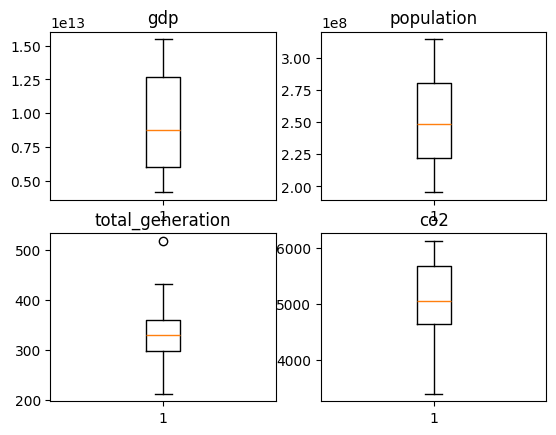

In [124]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].boxplot(train["gdp"])
axes[0, 0].set_title("gdp")
axes[0, 1].boxplot(train["population"])
axes[0, 1].set_title("population")
axes[1, 0].boxplot(train["total_generation"])
axes[1, 0].set_title("total_generation")
axes[1, 1].boxplot(train["co2"])
axes[1, 1].set_title("co2")


There are outliers in total_generation. We will handle it using IQR method

In [125]:
Q1 = train["total_generation"].quantile(0.25)
Q3 = train["total_generation"].quantile(0.75)
IQR = Q3 - Q1
train["total_generation"] = train["total_generation"].clip(Q1, Q3)

Double checking that there are no outliers now

Text(0.5, 1.0, 'co2')

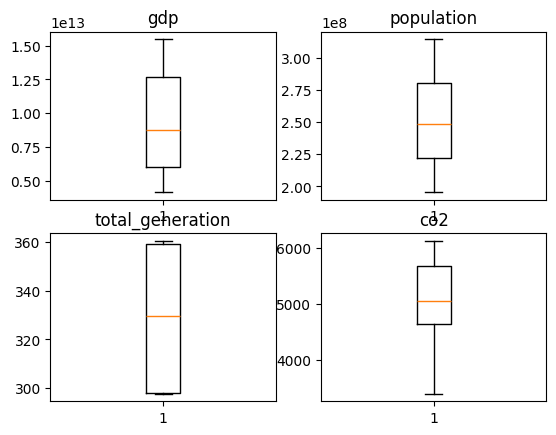

In [126]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].boxplot(train["gdp"])
axes[0, 0].set_title("gdp")
axes[0, 1].boxplot(train["population"])
axes[0, 1].set_title("population")
axes[1, 0].boxplot(train["total_generation"])
axes[1, 0].set_title("total_generation")
axes[1, 1].boxplot(train["co2"])
axes[1, 1].set_title("co2")


**Applying the same preprocessing steps onto the test set**

In [127]:
test["solar_generation"] = test["solar_generation"].fillna(0)
test["wind_generation"] = test["wind_generation"].fillna(0)
test["total_generation"] = test["solar_generation"] + test["wind_generation"] + test["hydro_generation"] + test["other_generation"]

Q1 = test["total_generation"].quantile(0.25)
Q3 = test["total_generation"].quantile(0.75)
IQR = Q3 - Q1
test["total_generation"] = test["total_generation"].clip(Q1, Q3)

In [128]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 47 to 58
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              12 non-null     int64  
 1   population        12 non-null     float64
 2   gdp               11 non-null     float64
 3   co2               12 non-null     float64
 4   solar_generation  12 non-null     float64
 5   wind_generation   12 non-null     float64
 6   hydro_generation  12 non-null     float64
 7   other_generation  12 non-null     float64
 8   total_generation  12 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 996.0 bytes


However, gdp is still missing value for an observation

In [129]:
test[test["gdp"].isna()]

,year,population,gdp,co2,solar_generation,wind_generation,hydro_generation,other_generation,total_generation
58,2023,343477332.0,NaN,4911.391,240.52525,429.5307,236.32129,67.2901,840.613915


Because this is the test set, we will remove this observation instead of imputating the value

In [130]:
test = test[test["gdp"].notna()]

**Exporting the cleaned data with only the required features**

In [131]:
train_cleaned = train[["gdp", "population", "total_generation", "co2"]]
test_cleaned = test[["gdp", "population", "total_generation", "co2"]]

In [132]:
train_cleaned.to_csv("data/cleaned_train.csv", index = False)
test_cleaned.to_csv("data/cleaned_test.csv", index = False)